In [1]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import *
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [3]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

In [4]:
ref = rIm[0]
alt = np.load('../flow_test/warped_npys_lowlight3_bunny3/warped_1.npy')

assert ref.shape == alt.shape
assert ref.dtype == alt.dtype

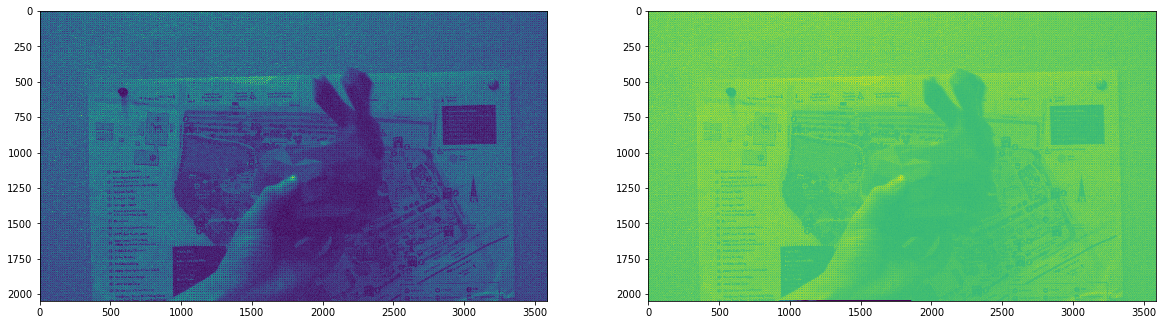

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(ref)
ax[1].imshow(alt)
plt.show()

In [6]:
import torch

# class MergeNet(torch.nn.Module):
#     def __init__(self, D_in, H, D_out):
#         super(MergeNet, self).__init__()
#         self.conv1 = torch.nn.Conv2d(8, 1, 16, stride = 8)

#     def forward(self, x):
#         """
#         In the forward function we accept a Tensor of input data and we must return
#         a Tensor of output data. We can use Modules defined in the constructor as
#         well as arbitrary operators on Tensors.
#         """
#         y_pred = self.conv1(x)
#         return y_pred

In [7]:
l1_kernel = torch.cat([torch.ones(1, 4, 16, 16), -torch.ones(1, 4, 16, 16)], dim = 1)
l1_kernel.requires_grad = True

In [8]:
ref_stack = raw_to_stack(ref)
alt_stack = raw_to_stack(alt)

In [9]:
ref_t = torch.from_numpy(ref_stack.copy().transpose(2, 0, 1))
alt_t = torch.from_numpy(alt_stack.copy().transpose(2, 0, 1))

In [10]:
inputs = torch.cat([ref_t, alt_t], dim = 0).unsqueeze(0)
inputs.size()

torch.Size([1, 8, 1024, 1792])

In [11]:
import torch.nn.functional as F
outputs = F.conv2d(inputs.float(), l1_kernel.float(), stride = 8)
print(outputs.size())

torch.Size([1, 1, 127, 223])


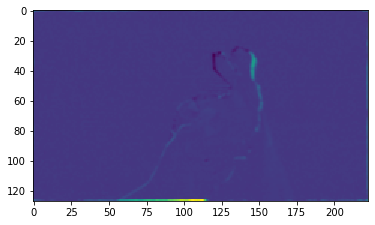

In [12]:
plt.imshow(outputs.detach().numpy()[0, 0])
plt.show()

In [13]:
mask = torch.sigmoid(torch.abs(outputs) - 1420.4)

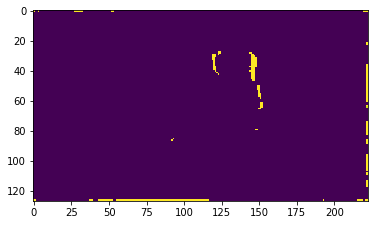

In [14]:
plt.imshow(mask.detach().numpy()[0, 0])
plt.show()

/home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


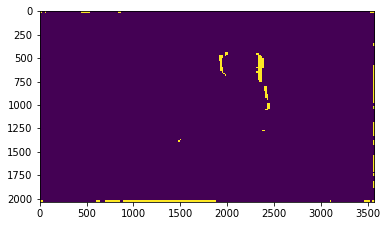

In [15]:
plt.imshow(F.upsample(mask, scale_factor=16, mode='nearest').detach().numpy()[0, 0])
plt.show()

In [16]:
mask.shape

torch.Size([1, 1, 127, 223])

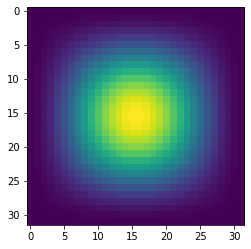

In [17]:
plt.imshow(raised_cosine_filter())
plt.show()

In [18]:
cos_win1 = raised_cosine_filter()[:16, :16]
cos_win2 = raised_cosine_filter()[16:, :16]
cos_win3 = raised_cosine_filter()[:16, 16:]
cos_win4 = raised_cosine_filter()[16:, 16:]


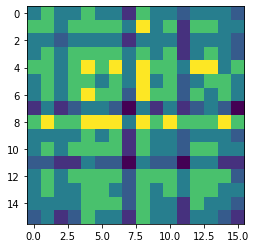

In [19]:
plt.imshow(cos_win1 + cos_win2 + cos_win3 + cos_win4)
# plt.colorbar()
plt.show()

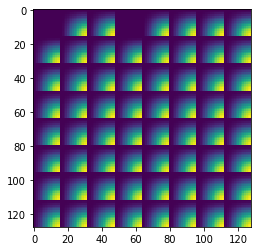

torch.Size([1, 1, 2032, 3568])


In [20]:
convmap1 = F.conv_transpose2d(1 - mask, torch.from_numpy(cos_win1.copy()).unsqueeze(0).unsqueeze(0).float(), stride=16)
plt.imshow(convmap1.detach().numpy()[0, 0, :128, :128])
plt.show()
print(convmap1.shape)

In [21]:
A = torch.Tensor([[[[1, 0], [1, 1]]]])
B = torch.Tensor([[[[1.5, 2.5, 2.2], [3.5, 4.5, 4.2], [1.1, 2.2, 3.3]]]])
F.conv_transpose2d(A, B, stride = 3)

tensor([[[[1.5000, 2.5000, 2.2000, 0.0000, 0.0000, 0.0000],
          [3.5000, 4.5000, 4.2000, 0.0000, 0.0000, 0.0000],
          [1.1000, 2.2000, 3.3000, 0.0000, 0.0000, 0.0000],
          [1.5000, 2.5000, 2.2000, 1.5000, 2.5000, 2.2000],
          [3.5000, 4.5000, 4.2000, 3.5000, 4.5000, 4.2000],
          [1.1000, 2.2000, 3.3000, 1.1000, 2.2000, 3.3000]]]])